#Dataset

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
DATA_DIR = '/content/gdrive/MyDrive/Celeb//img_align_celeba'


Mounted at /content/gdrive


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
# Import PyTorch and necessary modules
import torch
from torchvision.utils import make_grid
import torch.nn as nn
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [3]:
# Set the desired size for the images (assuming square images)
image_size = 64

# Set the batch size for data loading
batch_size = 128

# Define the normalization statistics for image preprocessing
# The statistics are usually mean and standard deviation for each color channel (RGB)
# The format is (mean_R, mean_G, mean_B), (std_R, std_G, std_B)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
# Define the transformation pipeline for the training dataset
# The pipeline includes resizing, center cropping, converting to tensor, and normalization
transform_pipeline = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

# Create the training dataset using the ImageFolder class and apply the transformation
train_ds = ImageFolder(DATA_DIR, transform=transform_pipeline)

# Create the DataLoader for the training dataset
# DataLoader is responsible for providing batches of data during training
# It shuffles the data, uses multiple workers for loading, and can be pinned to memory for acceleration
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1211
    Root location: /content/gdrive/MyDrive/Celeb//img_align_celeba
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
def denorm(img_tensors):
    """
    Denormalize image tensors.

    Args:
    - img_tensors (torch.Tensor): Input image tensor(s) to be denormalized.

    Returns:
    - torch.Tensor: Denormalized image tensor(s).
    """
    # Denormalization formula: (img * std) + mean
    # For simplicity, assuming a single channel (e.g., grayscale) in the normalization stats
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    """
    Display a grid of images.

    Args:
    - images (torch.Tensor): Input image tensor(s) to be displayed.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Create a subplot with no ticks
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])

    # Denormalize and display the image grid
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    """
    Display a batch of images from a DataLoader.

    Args:
    - dl (DataLoader): DataLoader providing batches of images.
    - nmax (int): Maximum number of images to display (default is 64).
    """
    # Iterate over batches in the DataLoader
    for images, _ in dl:
        # Display the images in the batch
        show_images(images, nmax)
        # Display only the first batch for simplicity
        break


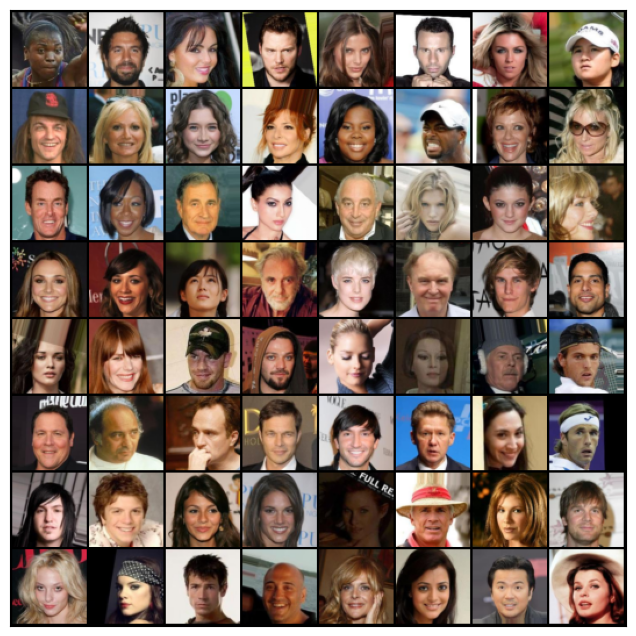

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a CUDA device if available
    else:
        return torch.device('cpu')  # Return a CPU device if no CUDA device is available

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        # Recursively move each element of the list or tuple to the specified device
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # Move the tensor to the specified device

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)  # Yield a batch of data after moving it to the specified device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)  # Return the number of batches in the wrapped dataloader


In [10]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
# Define the discriminator neural network architecture
discriminator = nn.Sequential(
    # Convolutional layer 1: Input channels (3 for RGB), output channels (64), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Convolutional layer 2: Input channels (64), output channels (128), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Convolutional layer 3: Input channels (128), output channels (256), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Convolutional layer 4: Input channels (256), output channels (512), kernel size (4x4),
    # stride (2), padding (1), no bias term, followed by batch normalization and LeakyReLU activation
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Convolutional layer 5: Input channels (512), output channels (1), kernel size (4x4),
    # stride (1), no padding, no bias term, followed by flattening and Sigmoid activation
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Output: 1 channel, 1 x 1 spatial dimensions

    # Flatten the output tensor to a 1D tensor
    nn.Flatten(),
    # Apply Sigmoid activation to the flattened tensor
    nn.Sigmoid()
)


In [12]:
discriminator = to_device(discriminator, device)

In [13]:
import torch.nn as nn

# Define the size of the latent vector
latent_size = 128

# Define the generator neural network architecture
generator = nn.Sequential(
    # Transposed convolutional layer 1: Input channels (latent_size), output channels (512),
    # kernel size (4x4), stride (1), no padding, no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Output: 512 channels, 4 x 4 spatial dimensions

    # Transposed convolutional layer 2: Input channels (512), output channels (256),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Output: 256 channels, 8 x 8 spatial dimensions

    # Transposed convolutional layer 3: Input channels (256), output channels (128),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Output: 128 channels, 16 x 16 spatial dimensions

    # Transposed convolutional layer 4: Input channels (128), output channels (64),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by batch normalization and ReLU activation
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Output: 64 channels, 32 x 32 spatial dimensions

    # Transposed convolutional layer 5: Input channels (64), output channels (3),
    # kernel size (4x4), stride (2), padding (1), no bias term,
    # followed by Tanh activation (to ensure output values are in the range [-1, 1])
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # Output: 3 channels (RGB), 64 x 64 spatial dimensions
)


In [14]:
generator = to_device(generator, device)

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)  # Forward pass for real images
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Real labels
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Binary cross-entropy loss
    real_score = torch.mean(real_preds).item()  # Mean prediction score for real images

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Fake labels
    fake_preds = discriminator(fake_images)  # Forward pass for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Binary cross-entropy loss
    fake_score = torch.mean(fake_preds).item()  # Mean prediction score for fake images

    # Update discriminator weights
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights
    return loss.item(), real_score, fake_score


In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Generate random latent vectors
    fake_images = generator(latent)  # Generate fake images using the generator

    # Try to fool the discriminator
    preds = discriminator(fake_images)  # Forward pass for fake images through the discriminator
    targets = torch.ones(batch_size, 1, device=device)  # Target labels (ones)
    loss = F.binary_cross_entropy(preds, targets)  # Binary cross-entropy loss

    # Update generator weights
    loss.backward()  # Backpropagation
    opt_g.step()  # Update generator weights

    return loss.item()  # Return the loss value as a scalar


Saving generated-images-0000.png


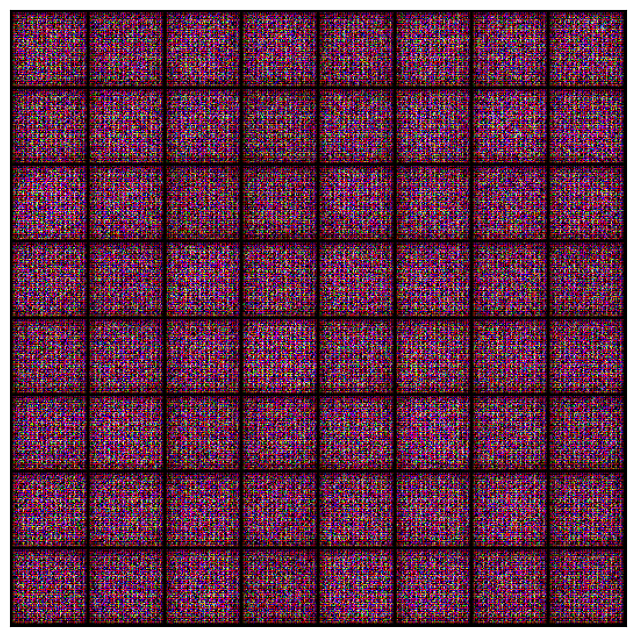

In [17]:
from torchvision.utils import save_image

# Specify the directory for saving generated samples
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    # Generate fake images using the generator
    fake_images = generator(latent_tensors)

    # Create a filename for the saved image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    # Save the generated images to the specified directory
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    # Optionally display the generated images
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        # Display the generated images in a grid using matplotlib
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# Generate fixed latent vectors for consistent sample generation
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Save and optionally display generated samples using the fixed latent vectors
save_samples(0, fixed_latent)


In [18]:
from tqdm import tqdm
def fit(epochs, lr, start_idx=1):
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Lists to store losses and scores during training
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for the discriminator and generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(epochs):
        # Iterate over batches in the training DataLoader
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores for the epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores for the last batch of the epoch
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images for the epoch
        save_samples(epoch+start_idx, fixed_latent, show=False)

    # Return the recorded losses and scores
    return losses_g, losses_d, real_scores, fake_scores


In [19]:
lr = 0.0002
epochs = 100
history = fit(epochs, lr)

100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Epoch [1/100], loss_g: 7.8164, loss_d: 0.3388, real_score: 0.9053, fake_score: 0.1702
Saving generated-images-0001.png


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch [2/100], loss_g: 15.0996, loss_d: 0.2296, real_score: 0.8428, fake_score: 0.0000
Saving generated-images-0002.png


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Epoch [3/100], loss_g: 14.8579, loss_d: 0.1636, real_score: 0.8729, fake_score: 0.0000
Saving generated-images-0003.png


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Epoch [4/100], loss_g: 5.3664, loss_d: 0.1150, real_score: 0.9709, fake_score: 0.0777
Saving generated-images-0004.png


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Epoch [5/100], loss_g: 12.3006, loss_d: 0.1639, real_score: 0.8795, fake_score: 0.0000
Saving generated-images-0005.png


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch [6/100], loss_g: 13.4072, loss_d: 0.2545, real_score: 0.8444, fake_score: 0.0002
Saving generated-images-0006.png


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Epoch [7/100], loss_g: 7.2505, loss_d: 0.1065, real_score: 0.9333, fake_score: 0.0249
Saving generated-images-0007.png


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [8/100], loss_g: 6.4643, loss_d: 0.2526, real_score: 0.8989, fake_score: 0.1155
Saving generated-images-0008.png


100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


Epoch [9/100], loss_g: 7.6009, loss_d: 0.1134, real_score: 0.9139, fake_score: 0.0075
Saving generated-images-0009.png


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch [10/100], loss_g: 6.2795, loss_d: 0.2364, real_score: 0.8856, fake_score: 0.0789
Saving generated-images-0010.png


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch [11/100], loss_g: 6.9070, loss_d: 0.0736, real_score: 0.9463, fake_score: 0.0132
Saving generated-images-0011.png


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch [12/100], loss_g: 6.4167, loss_d: 0.0563, real_score: 0.9762, fake_score: 0.0308
Saving generated-images-0012.png


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch [13/100], loss_g: 6.2173, loss_d: 0.0731, real_score: 0.9770, fake_score: 0.0464
Saving generated-images-0013.png


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch [14/100], loss_g: 5.2757, loss_d: 0.1036, real_score: 0.9405, fake_score: 0.0230
Saving generated-images-0014.png


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


Epoch [15/100], loss_g: 5.5959, loss_d: 0.0522, real_score: 0.9791, fake_score: 0.0299
Saving generated-images-0015.png


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Epoch [16/100], loss_g: 5.6181, loss_d: 0.0602, real_score: 0.9720, fake_score: 0.0286
Saving generated-images-0016.png


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch [17/100], loss_g: 5.2083, loss_d: 0.0526, real_score: 0.9655, fake_score: 0.0161
Saving generated-images-0017.png


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [18/100], loss_g: 5.9421, loss_d: 0.3366, real_score: 0.7624, fake_score: 0.0001
Saving generated-images-0018.png


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Epoch [19/100], loss_g: 2.2005, loss_d: 2.2098, real_score: 0.2285, fake_score: 0.0651
Saving generated-images-0019.png


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch [20/100], loss_g: 3.0597, loss_d: 0.3057, real_score: 0.8892, fake_score: 0.1637
Saving generated-images-0020.png


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch [21/100], loss_g: 4.7886, loss_d: 0.2522, real_score: 0.9318, fake_score: 0.1567
Saving generated-images-0021.png


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch [22/100], loss_g: 5.1563, loss_d: 0.2837, real_score: 0.9663, fake_score: 0.2157
Saving generated-images-0022.png


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Epoch [23/100], loss_g: 6.4094, loss_d: 0.2212, real_score: 0.8435, fake_score: 0.0149
Saving generated-images-0023.png


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Epoch [24/100], loss_g: 5.9261, loss_d: 0.3697, real_score: 0.9041, fake_score: 0.2181
Saving generated-images-0024.png


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Epoch [25/100], loss_g: 2.7609, loss_d: 0.4191, real_score: 0.8649, fake_score: 0.2241
Saving generated-images-0025.png


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch [26/100], loss_g: 2.6235, loss_d: 0.6891, real_score: 0.5762, fake_score: 0.0352
Saving generated-images-0026.png


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch [27/100], loss_g: 4.9886, loss_d: 3.0789, real_score: 0.0794, fake_score: 0.0015
Saving generated-images-0027.png


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [28/100], loss_g: 3.1306, loss_d: 0.6666, real_score: 0.7677, fake_score: 0.3031
Saving generated-images-0028.png


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Epoch [29/100], loss_g: 1.8169, loss_d: 0.3852, real_score: 0.7954, fake_score: 0.1086
Saving generated-images-0029.png


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch [30/100], loss_g: 3.5361, loss_d: 0.4740, real_score: 0.6805, fake_score: 0.0337
Saving generated-images-0030.png


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Epoch [31/100], loss_g: 3.3552, loss_d: 0.3926, real_score: 0.7253, fake_score: 0.0387
Saving generated-images-0031.png


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch [32/100], loss_g: 5.1008, loss_d: 0.8751, real_score: 0.9778, fake_score: 0.4920
Saving generated-images-0032.png


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [33/100], loss_g: 2.9913, loss_d: 2.1133, real_score: 0.2162, fake_score: 0.0025
Saving generated-images-0033.png


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch [34/100], loss_g: 4.9625, loss_d: 0.4826, real_score: 0.9871, fake_score: 0.3400
Saving generated-images-0034.png


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch [35/100], loss_g: 6.8660, loss_d: 0.9856, real_score: 0.9628, fake_score: 0.5385
Saving generated-images-0035.png


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch [36/100], loss_g: 4.1140, loss_d: 0.5402, real_score: 0.9540, fake_score: 0.3338
Saving generated-images-0036.png


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Epoch [37/100], loss_g: 4.2375, loss_d: 0.3293, real_score: 0.8008, fake_score: 0.0470
Saving generated-images-0037.png


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch [38/100], loss_g: 3.7830, loss_d: 0.4006, real_score: 0.8054, fake_score: 0.1114
Saving generated-images-0038.png


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [39/100], loss_g: 5.3605, loss_d: 1.0810, real_score: 0.9532, fake_score: 0.5817
Saving generated-images-0039.png


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch [40/100], loss_g: 2.2935, loss_d: 0.4886, real_score: 0.7177, fake_score: 0.1034
Saving generated-images-0040.png


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch [41/100], loss_g: 9.3704, loss_d: 0.9482, real_score: 0.9672, fake_score: 0.5551
Saving generated-images-0041.png


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch [42/100], loss_g: 3.6834, loss_d: 0.4092, real_score: 0.8580, fake_score: 0.1930
Saving generated-images-0042.png


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Epoch [43/100], loss_g: 8.2694, loss_d: 0.5178, real_score: 0.9174, fake_score: 0.3059
Saving generated-images-0043.png


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch [44/100], loss_g: 2.4605, loss_d: 0.8908, real_score: 0.6214, fake_score: 0.2556
Saving generated-images-0044.png


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch [45/100], loss_g: 3.1780, loss_d: 0.3985, real_score: 0.8735, fake_score: 0.2058
Saving generated-images-0045.png


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch [46/100], loss_g: 4.4220, loss_d: 0.3794, real_score: 0.8945, fake_score: 0.2122
Saving generated-images-0046.png


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


Epoch [47/100], loss_g: 4.3174, loss_d: 0.3642, real_score: 0.8376, fake_score: 0.1401
Saving generated-images-0047.png


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Epoch [48/100], loss_g: 2.8371, loss_d: 1.8628, real_score: 0.2638, fake_score: 0.0052
Saving generated-images-0048.png


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch [49/100], loss_g: 3.8884, loss_d: 0.4121, real_score: 0.8852, fake_score: 0.2228
Saving generated-images-0049.png


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch [50/100], loss_g: 9.6524, loss_d: 2.1905, real_score: 0.9841, fake_score: 0.8022
Saving generated-images-0050.png


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Epoch [51/100], loss_g: 4.7953, loss_d: 0.4811, real_score: 0.8653, fake_score: 0.2578
Saving generated-images-0051.png


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch [52/100], loss_g: 2.7730, loss_d: 0.4415, real_score: 0.7350, fake_score: 0.0798
Saving generated-images-0052.png


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Epoch [53/100], loss_g: 3.3575, loss_d: 0.3661, real_score: 0.8345, fake_score: 0.1364
Saving generated-images-0053.png


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Epoch [54/100], loss_g: 3.9480, loss_d: 0.2244, real_score: 0.9096, fake_score: 0.1115
Saving generated-images-0054.png


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch [55/100], loss_g: 3.4905, loss_d: 0.2463, real_score: 0.8732, fake_score: 0.0811
Saving generated-images-0055.png


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch [56/100], loss_g: 1.9119, loss_d: 1.1013, real_score: 0.4406, fake_score: 0.0251
Saving generated-images-0056.png


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch [57/100], loss_g: 4.7487, loss_d: 0.4432, real_score: 0.8589, fake_score: 0.2197
Saving generated-images-0057.png


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Epoch [58/100], loss_g: 5.8438, loss_d: 0.6381, real_score: 0.9677, fake_score: 0.4050
Saving generated-images-0058.png


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch [59/100], loss_g: 3.9649, loss_d: 0.3229, real_score: 0.7584, fake_score: 0.0038
Saving generated-images-0059.png


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch [60/100], loss_g: 3.4205, loss_d: 0.3570, real_score: 0.8347, fake_score: 0.1381
Saving generated-images-0060.png


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch [61/100], loss_g: 2.7388, loss_d: 0.3393, real_score: 0.7954, fake_score: 0.0728
Saving generated-images-0061.png


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch [62/100], loss_g: 3.5748, loss_d: 0.5392, real_score: 0.9681, fake_score: 0.3494
Saving generated-images-0062.png


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Epoch [63/100], loss_g: 2.4023, loss_d: 0.5197, real_score: 0.6764, fake_score: 0.0398
Saving generated-images-0063.png


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Epoch [64/100], loss_g: 5.0673, loss_d: 0.4076, real_score: 0.8916, fake_score: 0.2353
Saving generated-images-0064.png


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch [65/100], loss_g: 6.5180, loss_d: 0.4195, real_score: 0.9863, fake_score: 0.2814
Saving generated-images-0065.png


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch [66/100], loss_g: 5.2929, loss_d: 0.2585, real_score: 0.9394, fake_score: 0.1644
Saving generated-images-0066.png


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch [67/100], loss_g: 6.6250, loss_d: 0.6405, real_score: 0.9351, fake_score: 0.3913
Saving generated-images-0067.png


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Epoch [68/100], loss_g: 4.3892, loss_d: 0.3617, real_score: 0.8699, fake_score: 0.1704
Saving generated-images-0068.png


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch [69/100], loss_g: 1.0673, loss_d: 0.7438, real_score: 0.6193, fake_score: 0.0862
Saving generated-images-0069.png


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch [70/100], loss_g: 2.8399, loss_d: 0.4705, real_score: 0.8392, fake_score: 0.2219
Saving generated-images-0070.png


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Epoch [71/100], loss_g: 2.8737, loss_d: 0.4852, real_score: 0.7287, fake_score: 0.1004
Saving generated-images-0071.png


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch [72/100], loss_g: 8.1152, loss_d: 0.8587, real_score: 0.9846, fake_score: 0.5056
Saving generated-images-0072.png


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


Epoch [73/100], loss_g: 5.5811, loss_d: 0.5431, real_score: 0.9771, fake_score: 0.3656
Saving generated-images-0073.png


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch [74/100], loss_g: 3.3863, loss_d: 0.3116, real_score: 0.8038, fake_score: 0.0585
Saving generated-images-0074.png


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch [75/100], loss_g: 1.4168, loss_d: 0.6388, real_score: 0.5947, fake_score: 0.0070
Saving generated-images-0075.png


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch [76/100], loss_g: 2.8965, loss_d: 0.5244, real_score: 0.8069, fake_score: 0.2133
Saving generated-images-0076.png


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch [77/100], loss_g: 5.6418, loss_d: 0.4549, real_score: 0.9147, fake_score: 0.2776
Saving generated-images-0077.png


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [78/100], loss_g: 3.4148, loss_d: 0.5483, real_score: 0.6619, fake_score: 0.0165
Saving generated-images-0078.png


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch [79/100], loss_g: 2.4626, loss_d: 0.1577, real_score: 0.8958, fake_score: 0.0326
Saving generated-images-0079.png


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch [80/100], loss_g: 3.5188, loss_d: 0.5307, real_score: 0.7161, fake_score: 0.1168
Saving generated-images-0080.png


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch [81/100], loss_g: 3.3858, loss_d: 0.4614, real_score: 0.6920, fake_score: 0.0355
Saving generated-images-0081.png


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Epoch [82/100], loss_g: 1.7711, loss_d: 0.5267, real_score: 0.6988, fake_score: 0.0892
Saving generated-images-0082.png


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch [83/100], loss_g: 3.2303, loss_d: 0.3665, real_score: 0.8329, fake_score: 0.1371
Saving generated-images-0083.png


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Epoch [84/100], loss_g: 3.1577, loss_d: 0.4021, real_score: 0.7683, fake_score: 0.0863
Saving generated-images-0084.png


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Epoch [85/100], loss_g: 3.6725, loss_d: 0.3741, real_score: 0.8056, fake_score: 0.1151
Saving generated-images-0085.png


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Epoch [86/100], loss_g: 2.8013, loss_d: 0.2450, real_score: 0.8578, fake_score: 0.0654
Saving generated-images-0086.png


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch [87/100], loss_g: 1.7739, loss_d: 0.7242, real_score: 0.5505, fake_score: 0.0310
Saving generated-images-0087.png


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch [88/100], loss_g: 4.3596, loss_d: 0.6099, real_score: 0.8321, fake_score: 0.3031
Saving generated-images-0088.png


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


Epoch [89/100], loss_g: 6.8811, loss_d: 1.1321, real_score: 0.9809, fake_score: 0.5698
Saving generated-images-0089.png


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch [90/100], loss_g: 4.2071, loss_d: 0.4471, real_score: 0.6959, fake_score: 0.0176
Saving generated-images-0090.png


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Epoch [91/100], loss_g: 4.9991, loss_d: 0.1903, real_score: 0.9160, fake_score: 0.0801
Saving generated-images-0091.png


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Epoch [92/100], loss_g: 3.3290, loss_d: 0.5750, real_score: 0.6109, fake_score: 0.0119
Saving generated-images-0092.png


100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Epoch [93/100], loss_g: 1.2516, loss_d: 0.8509, real_score: 0.5232, fake_score: 0.0205
Saving generated-images-0093.png


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Epoch [94/100], loss_g: 3.1121, loss_d: 0.4674, real_score: 0.7353, fake_score: 0.1022
Saving generated-images-0094.png


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch [95/100], loss_g: 2.8653, loss_d: 0.4918, real_score: 0.7459, fake_score: 0.1415
Saving generated-images-0095.png


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch [96/100], loss_g: 2.5334, loss_d: 0.4768, real_score: 0.6780, fake_score: 0.0242
Saving generated-images-0096.png


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Epoch [97/100], loss_g: 2.7743, loss_d: 0.3745, real_score: 0.7466, fake_score: 0.0440
Saving generated-images-0097.png


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Epoch [98/100], loss_g: 1.7283, loss_d: 0.5389, real_score: 0.6583, fake_score: 0.0280
Saving generated-images-0098.png


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Epoch [99/100], loss_g: 2.2560, loss_d: 0.9643, real_score: 0.4810, fake_score: 0.0631
Saving generated-images-0099.png


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

Epoch [100/100], loss_g: 4.6340, loss_d: 0.3847, real_score: 0.7429, fake_score: 0.0391
Saving generated-images-0100.png


In [20]:
losses_g, losses_d, real_scores, fake_scores = history

In [21]:
# Save the trained generator model's state dictionary to a file
torch.save(generator.state_dict(), 'G.pth')

# Save the trained discriminator model's state dictionary to a file
torch.save(discriminator.state_dict(), 'D.pth')


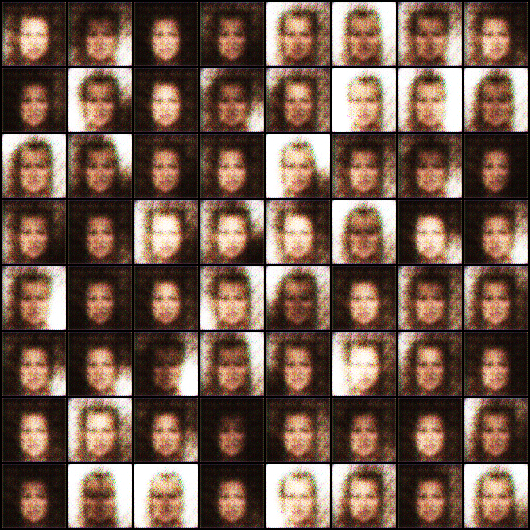

In [25]:
from IPython.display import Image
Image('/content/gdrive/MyDrive//generated/generated-images-0026.png')